In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import DaskDistributedSampler
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [3]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=10, threads_per_worker = 1)
client = Client(c,timeout=90)

In [4]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'0_4_Adults_mean': 17152.0,
 '10_4_Adults_mean': 14350.0,
 '20_4_Adults_mean': 11823.0,
 '40_4_Adults_mean': 12679.0,
 '80_4_Adults_mean': 12095.0,
 '160_4_Adults_mean': 11954.0,
 '0_5_Adults_mean': 19216.0,
 '10_5_Adults_mean': 17330.0,
 '20_5_Adults_mean': 15110.0,
 '40_5_Adults_mean': 10917.0,
 '80_5_Adults_mean': 7923.0,
 '160_5_Adults_mean': 5980.0,
 '0_6_Adults_mean': 18229.0,
 '10_6_Adults_mean': 17481.0,
 '20_6_Adults_mean': 17078.0,
 '40_6_Adults_mean': 15322.0,
 '80_6_Adults_mean': 6599.0,
 '160_6_Adults_mean': 2245.0,
 '0_7_Adults_mean': 12589.0,
 '10_7_Adults_mean': 14229.0,
 '20_7_Adults_mean': 18951.0,
 '40_7_Adults_mean': 17520.0,
 '80_7_Adults_mean': 16514.0,
 '160_7_Adults_mean': 478.0,
 '0_4_Adults_sd': 3874.0,
 '10_4_Adults_sd': 5023.0,
 '20_4_Adults_sd': 4745.0,
 '40_4_Adults_sd': 5132.0,
 '80_4_Adults_sd': 4682.0,
 '160_4_Adults_sd': 3807.0,
 '0_5_Adults_sd': 4729.0,
 '10_5_Adults_sd': 3807.0,
 '20_5_Adults_sd': 5023.0,
 '40_5_Adults_sd': 4847.0,
 '80_5_Adults_sd'

In [5]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0.0001, .5),
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0.0001,.5),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              #AIAdultLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultLD50=(-4, -.3), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultSlope=(1, 9),
              #AILarvaLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaLD50=(-4,-.3), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [6]:
# Set our distance function and sampler
#distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True)
distance = PNormDistance(p=2)

sampler = DaskDistributedSampler(dask_client = client)


In [7]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=3,#AdaptivePopulationSize(500, max_population_size = 600),
             sampler=sampler)

In [8]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_16.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=2, start_time=2018-11-16 14:29:57.477884, end_time=None)>


KeyboardInterrupt: 

In [ ]:
history = abc.run(max_nr_populations=2, minimum_epsilon=0)

In [12]:
history.get_distribution(m=0)

NameError: name 'history' is not defined

### Visualize results

In [ ]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

### Visualize from a stored run

In [17]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_9.db"))
history = History(db_path)
history.id = 1

df, w = history.get_distribution(m=0)


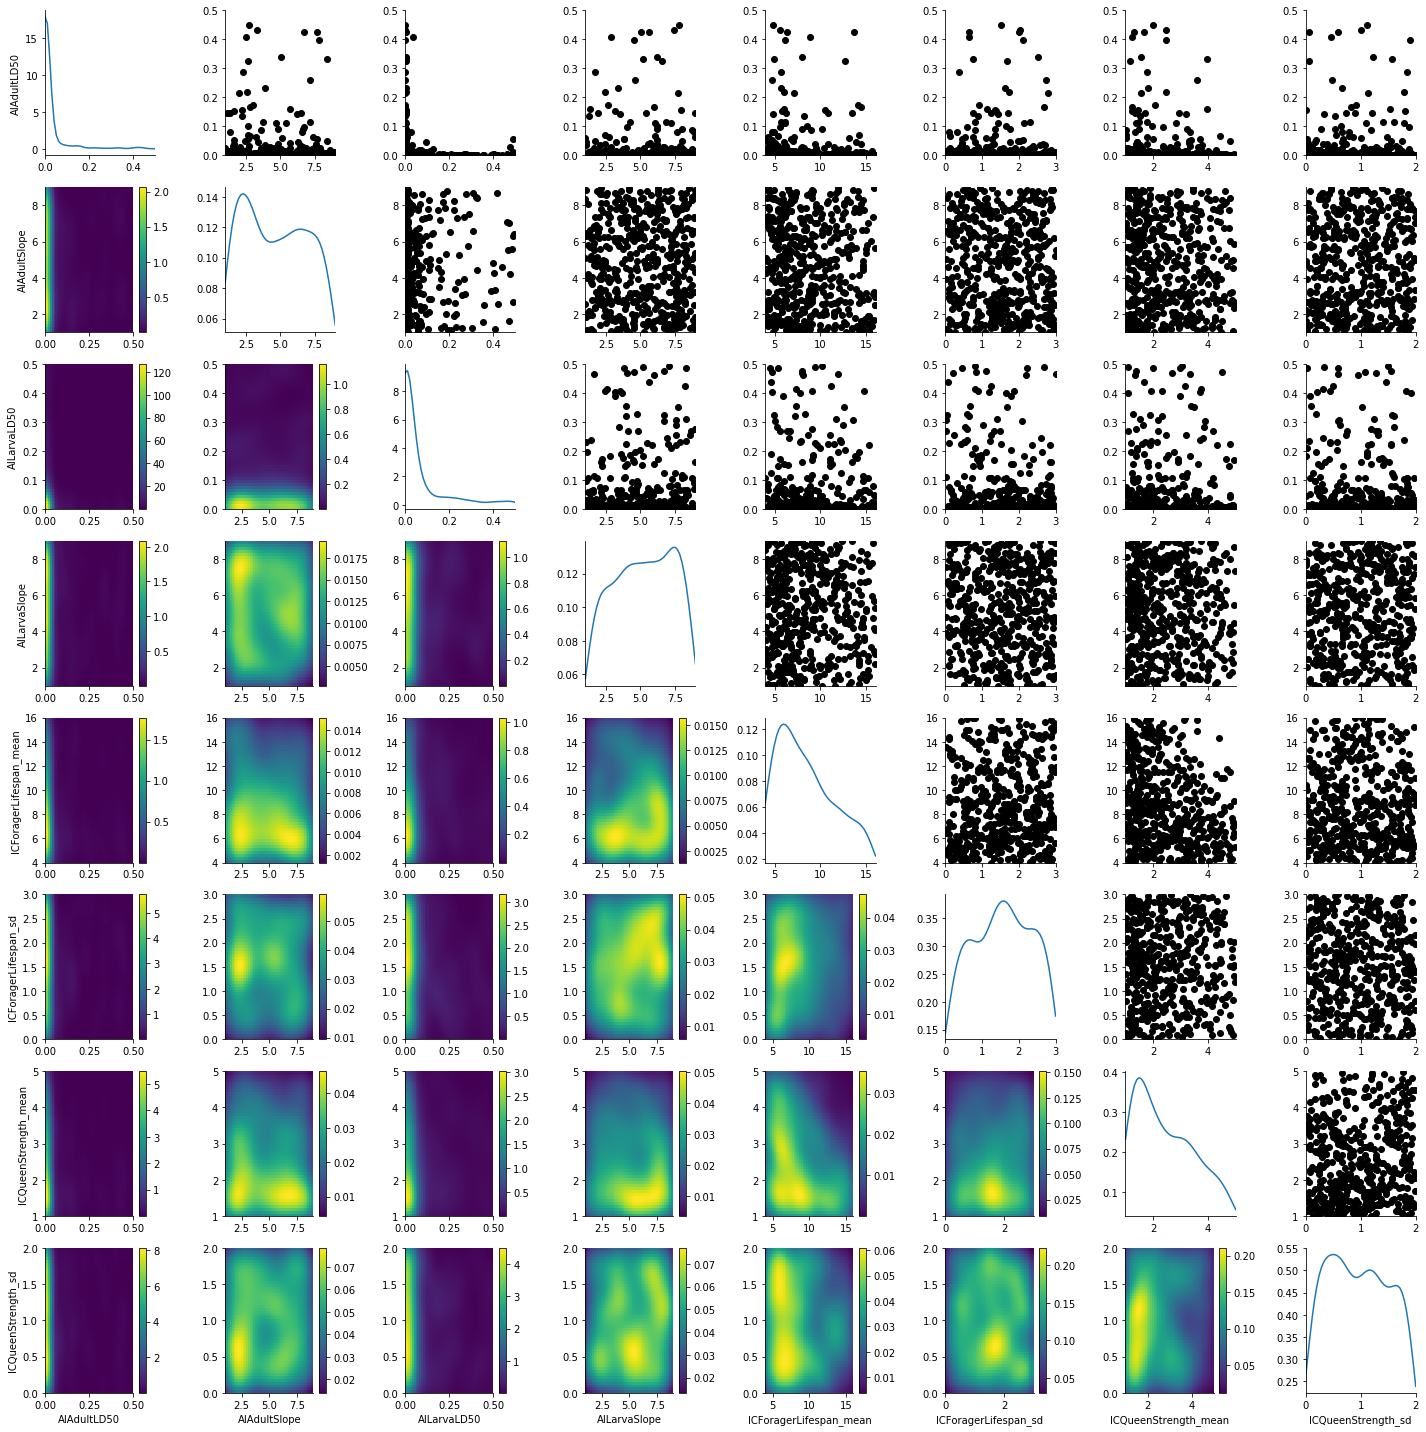

In [22]:
plot_kde_matrix(df, w, limits=limits);

In [21]:
df

name,AIAdultLD50,AIAdultSlope,AILarvaLD50,AILarvaSlope,ICForagerLifespan_mean,ICForagerLifespan_sd,ICQueenStrength_mean,ICQueenStrength_sd
id,,,,,,,,
2,0.000217,2.256774,0.001196,7.839776,7.975347,1.662404,4.418732,1.874355
3,0.001421,5.854348,0.051163,3.382179,6.704028,2.743720,3.489857,0.086726
4,0.001941,7.166098,0.155798,4.052319,11.232196,1.794804,1.288981,1.185865
5,0.000108,1.635304,0.065135,6.400560,4.262771,0.146924,1.192315,0.592633
6,0.010151,6.124068,0.000241,4.387546,4.688398,0.468832,1.882875,1.197399
7,0.000359,4.934499,0.000143,1.667497,10.381466,1.936282,2.755723,0.329526
8,0.000464,7.217480,0.076386,6.202530,5.399940,0.651162,2.315572,1.838294
9,0.000683,3.196090,0.000307,2.164079,4.318185,2.735842,3.764436,0.180898
10,0.014677,5.209955,0.000251,1.447949,7.718076,2.219668,2.895900,1.677104


In [19]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-09 15:02:31.514564,0,0.000000,1
1,0,2018-11-10 06:51:11.306424,1025,68980.154997,500


In [20]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-09 15:02:20.743506, end_time=None)>]

In [31]:
np.median(df['AIAdultLD50']), np.mean(df['AIAdultLD50'])

(0.0016154300451063145, 0.01989726205951236)

In [32]:
np.median(df['AILarvaLD50']), np.mean(df['AILarvaLD50'])

(0.0037242077659434634, 0.04998197909299795)

In [2]:
client

NameError: name 'client' is not defined